見つかった不具合(1)<br>
ストランドがa,a*しかない、あるいはb,b*しかない場合、*_peppercorn_output.pilに無い方のストランド長が書かれないので、main.pyがうまくファイルを読み取れずに失敗する。<br><br>
見つかった不具合(2)<br>
peppercornがそのストランド組み合わせで構造を発見できず、エネルギーの値を持たないenergy_log.csv,oxdna_energy_mean.csvだけが残る場合がある。

2023/9/4<br>
strands.csvを生成して行う処理は都合が悪いので、使わない方向に修正を試みる。

In [90]:
import os
import importlib
import warnings
warnings.filterwarnings('ignore')
import use_pickle
importlib.reload(use_pickle)
import make_filepath
importlib.reload(make_filepath)
import glob
import pandas as pd
#from contextlib import redirect_stdout
#with redirect_stdout(open(<出力先パス>), 'w')): 処理
import traceback
import time
import datetime
import sys
import shutil

In [91]:
import get_untrusted
importlib.reload(get_untrusted)
import qdpy_result_to_strands
importlib.reload(qdpy_result_to_strands)
import run_peppercorn
importlib.reload(run_peppercorn)
import run_oxdna
importlib.reload(run_oxdna)
import pil_to_strands
importlib.reload(pil_to_strands)
import send_mail
importlib.reload(send_mail)
import check_structures
importlib.reload(check_structures)

<module 'check_structures' from '/Users/takepy/takeoxdna/kakenhievolvedna2/oxdna_run/check_structures.py'>

In [92]:
def send_test_loop_mail(flag,error_message,start_datetime,end_datetime,elapsed_time):
    if flag == "okey":
        importlib.reload(send_mail)
        textlist = ["🎉🎉🎉Python program  【test_loop】 completed!🎉🎉🎉","\n",
                    "⏰START: ",start_datetime,"\n",
                    "⏰END: ",end_datetime,"\n",
                    "⌛️RUN TIME: ",str(elapsed_time)," s \n",
                    "📃MESSAGE: ",error_message]
        text = "".join(textlist)
        send_mail.program_complete_mail(mail_title = "🐍【実行完了】 Pythonプログラム【test_loop】 が完了しました！🐍",mailtext = text)
    else:
        importlib.reload(send_mail)
        textlist = ["😭😭Python program 【test_loop】 has ERROR!😭😭","\n",
                    "⏰START: ",start_datetime,"\n",
                    "⏰END: ",end_datetime,"\n",
                    "⌛️RUN TIME: ",str(elapsed_time)," s \n",
                    "📃MESSAGE: ",error_message]
        text = "".join(textlist)
        send_mail.program_complete_mail(mail_title = "🐍【実行エラー】 Pythonプログラム 【test_loop】 でエラーが発生しました🐍",mailtext = text)

In [93]:
def concat_abs(binary_energy_df):
    qdpy_oxdna_abs = abs(
        binary_energy_df.loc[:,"qdpy_bootstrap_energy_mean"] - \
        binary_energy_df.loc[:,"oxdna_energy_mean"]
    ).rename("qdpy_oxdna_abs")
    
    return pd.concat(
        [binary_energy_df,#.loc[:,"qdpy_bootstrap_energy_mean":"oxdna_energy_mean"],
         qdpy_oxdna_abs],
        axis=1)

In [94]:
def choose_best_abs(binary_energy_df_abs,ratio=0.7):
    return binary_energy_df_abs.\
        dropna(how='any').\
        sort_values(by="qdpy_oxdna_abs", ascending=True).\
        head(int(len(binary_energy_df_abs)*ratio))

In [95]:
def get_untrusted_strands(source_dir,loop_dir):
    untrusted_df = get_untrusted.qdpy_to_untrusted_strands(source_dir,loop_dir,500)
    untrusted_tetrad = qdpy_result_to_strands.tf_to_tetrad(untrusted_df.iloc[:,:256].values)
    untrusted_strands = qdpy_result_to_strands.tetrad_to_strand(untrusted_tetrad)
        #qdpyにより、配置されたストランドの情報とエネルギーの情報が得られる。
        #生成されたファイルはloop_dirに置かれる。
        
    return untrusted_df,untrusted_strands

In [96]:
#make_new_train_dataは生成元と生成先のディレクトリ、ストランドの長さ、構造サイズの最大値を受け取る。
#返り値は新しくモデルに与えるx,yのトレーニング用データである。

def make_new_train_data(strands_df,source_dir,loop_dir,
                        length_a,length_b,max_complex_size,
                        oxdna_input_filename):

    x_train,x_test,y_train,y_test,\
        untrusted_df,qdpy_binary,\
            qdpy_tetrad,qdpy_strands = get_untrusted.get_untrusted_binary_and_energy(
                strands_df,source_dir,loop_dir,qdpy_bgt=1000)
        #qdpyにより、配置されたストランドの情報とエネルギーの情報が得られる。
        #生成されたファイルはloop_dirに置かれる。
    use_pickle.dump_to_pickle(loop_dir,[x_train,x_test,y_train,y_test],["x_train","x_test","y_train","y_test"])
    
    use_pickle.dump_to_pickle(loop_dir,[strands_df],["strands_df"])
    use_pickle.dump_to_pickle(loop_dir,[untrusted_df],["untrusted_df"])

    untrusted_strands = qdpy_result_to_strands.tetrad_to_strand(
        qdpy_result_to_strands.tf_to_tetrad(untrusted_df.iloc[:,0:256].values))
    
    untrusted_peppercorn_folders = run_peppercorn.run_peppercorn_for_list(
        # qdpy_strands,
        untrusted_strands,
        untrusted_df.index,
        #strands_df.loc[:,"strand_set_num"].values,
        length_a,length_b,max_complex_size,loop_dir)
    
    run_oxdna.run_oxdna_for_folders_list(untrusted_peppercorn_folders,
                                         loop_dir+"/run_oxdna_log.txt",
                                         oxdna_input_filename
                                         )


    untrusted_oxdna_energy_means = []
    for untrusted_idx in untrusted_df.index:
        energy_mean_path = os.path.join(loop_dir,
                    "untrusted_strands_set{}".format(str(untrusted_idx)),
                    "oxdna_outputs".format(str(untrusted_idx)),
                    "oxdna_energy_mean.csv")
        if os.path.exists(energy_mean_path):
            energy_mean = float(pd.read_csv(energy_mean_path).values[0])#oxdnaが計算した結果の平均。
            untrusted_oxdna_energy_means.append(energy_mean)

        else:
            untrusted_oxdna_energy_means.append(None)#構造が見つからなかった場合の結果である。

    energy_means_df = pd.DataFrame(untrusted_oxdna_energy_means)
    energy_means_df.columns = ["oxdna_energy_mean"]
    energy_means_df.index = untrusted_df.index#energy_means_dfとuntrusted_dfの並び順が同じであることを明示している。
    binary_energy_df = pd.concat([untrusted_df,energy_means_df],axis=1)

    additional_x_train = binary_energy_df.dropna(how='any').iloc[:,0:256]#再学習対象に追加したいデータ。Noneになっている部分は除外。
    additional_y_train = binary_energy_df.dropna(how='any').loc[:,"oxdna_energy_mean"]#再学習対象に追加したいデータ。
    # new_x_train = pd.concat([use_pickle.read_pickle(loop_dir+"/x_train.p"),additional_x_train],axis=0).reset_index(drop=True)
    # new_y_train = pd.concat([use_pickle.read_pickle(loop_dir+"/y_train.p"),additional_y_train],axis=0).reset_index(drop=True)
    new_x_train = pd.concat([x_train,additional_x_train],axis=0).reset_index(drop=True)
    new_y_train = pd.concat([y_train,additional_y_train],axis=0).reset_index(drop=True)
    #oxDNAした結果は今のところ全て再学習に使う。
    return new_x_train,new_y_train,binary_energy_df

In [97]:
def run_loop(output_dir,first_source_dir,
             length_a,length_b,max_complex_size,loop_num,
             oxdna_input_filename="input_relax_1e7"):
    #時間計測開始
    t1 = time.time()
    starttime = datetime.datetime.fromtimestamp(time.time())
    start_datetime = starttime.strftime('%Y/%m/%d %H:%M:%S')
    
    #時間を元に、結果フォルダ作成
    results_dir = make_filepath.make_datetime_folder(output_dir)
    #例:2023-07-31/20230802_1925

    #指定回数だけ、計算結果ファイル生成の一連の過程を実行する。
    
    for count in range(loop_num):
        try:
            #pilファイルの一覧を取得する。
            if count == 0:
                source_dir = first_source_dir
                loop_dir = make_filepath.make_count_folder(results_dir,count)
                #例:2023-07-31/20230802_1925/loop0
                source_pilfile_path_list = glob.glob(os.path.join(source_dir,"sim_result_peppercorn*","*_result.pil"))
                
            else:
                source_dir = os.path.join(results_dir,"loop"+str(count-1))
                loop_dir = make_filepath.make_count_folder(results_dir,count)
                source_pilfile_path_list = glob.glob(os.path.join(source_dir,"untrusted_strands_set*","peppercorn_output.pil"))

            #取得したファイルをもとに、ストランドのデータをまとめる。

            print("source_pilfile_path_list:\n")
            display(source_pilfile_path_list)

            strands_df = pil_to_strands.get_all_strands(source_pilfile_path_list)#strand_num,strand_set_id,strand_set_num,pilfile_path

            display(strands_df)
            
            
            new_x_train,new_y_train,binary_energy_df = make_new_train_data(
                strands_df,source_dir,loop_dir,
                length_a,length_b,max_complex_size,
                oxdna_input_filename)

            binary_energy_df_abs = concat_abs(binary_energy_df)
            oxdna_repertoire = choose_best_abs(binary_energy_df_abs,ratio=0.7)

            next_dir = make_filepath.make_count_folder(results_dir,count+1)
            use_pickle.dump_to_pickle(make_filepath.make_count_folder(results_dir,count+1),
                                    [new_x_train,new_y_train],
                                    ["x_train","y_train"]) 
            # shutil.copy(loop_dir+"/x_test.p",next_dir)
            # shutil.copy(loop_dir+"/y_test.p",next_dir)
            use_pickle.dump_to_pickle(loop_dir,[oxdna_repertoire],["oxdna_repertoire"])
            flag = "okey"
            error_message = "Succeeded!"
            
        except Exception as e:
            flag = str(e)
            error_message = traceback.format_exc()
            print(error_message)
            t2 = time.time()
            elapsed_time = t2-t1
            endtime = datetime.datetime.fromtimestamp(time.time())
            end_datetime = endtime.strftime('%Y/%m/%d %H:%M:%S')
            send_test_loop_mail(flag,error_message,start_datetime,end_datetime,elapsed_time)
            return 0
            
        
        count = count + 1


#エラーが起こった場合の処理

    #終了時刻を求め、実行時間をはかる。
    t2 = time.time()
    elapsed_time = t2-t1
    endtime = datetime.datetime.fromtimestamp(time.time())
    end_datetime = endtime.strftime('%Y/%m/%d %H:%M:%S')
    #終了を通知する。
    send_test_loop_mail(flag,error_message,start_datetime,end_datetime,elapsed_time)

    
    # check_structures.count_structures(output_dir,
    #                                   os.path.basename(results_dir),loop_num)

In [98]:
def main(args):
    output_dir = args[1]
    first_source_dir = args[2]
    length_a = int(args[3])
    length_b = int(args[4])
    max_complex_size = int(args[5])
    loop_num = int(args[6])
    oxdna_input_filename = args[7]
    run_loop(output_dir,first_source_dir,
             length_a,length_b,max_complex_size,loop_num,
             oxdna_input_filename)

source_pilfile_path_list:



['20230904_0000/sim_result_peppercorn_2022-12-19_21_40_29833963/0020_result.pil',
 '20230904_0000/sim_result_peppercorn_2022-12-19_21_56_36509379/0007_result.pil',
 '20230904_0000/sim_result_peppercorn_2022-12-19_21_58_14663161/0015_result.pil',
 '20230904_0000/sim_result_peppercorn_2022-12-19_21_55_35367237/0013_result.pil',
 '20230904_0000/sim_result_peppercorn_2022-12-19_21_42_49735508/0030_result.pil',
 '20230904_0000/sim_result_peppercorn_2022-12-19_21_51_37172207/0017_result.pil',
 '20230904_0000/sim_result_peppercorn_2022-12-19_21_46_25897742/0014_result.pil',
 '20230904_0000/sim_result_peppercorn_2022-12-19_21_36_49652412/0014_result.pil',
 '20230904_0000/sim_result_peppercorn_2022-12-19_21_44_00734003/0036_result.pil',
 '20230904_0000/sim_result_peppercorn_2022-12-19_22_00_25774786/0004_result.pil',
 '20230904_0000/sim_result_peppercorn_2022-12-19_21_45_43742850/0018_result.pil',
 '20230904_0000/sim_result_peppercorn_2022-12-19_21_54_23793562/0028_result.pil',
 '20230904_0000/

path: 20230904_0000/sim_result_peppercorn_2022-12-19_21_40_29833963/0020_result.pil
[['s0', '0002', 2, ['a', 'a', 'a', 'a*'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_40_29833963/0020_result.pil'], ['s1', '1010', 68, ['b', 'a', 'b', 'a'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_40_29833963/0020_result.pil'], ['s2', '3232', 238, ['b*', 'a*', 'b*', 'a*'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_40_29833963/0020_result.pil']]
[['s0', '0002', 2, ['a', 'a', 'a', 'a*'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_40_29833963/0020_result.pil'], ['s1', '1010', 68, ['b', 'a', 'b', 'a'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_40_29833963/0020_result.pil'], ['s2', '3232', 238, ['b*', 'a*', 'b*', 'a*'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_40_29833963/0020_result.pil']]
[['s0', '0002', 2, ['a', 'a', 'a', 'a*'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_40_29833963/0020_result.pil'], ['s1', '1010', 68, ['b', 'a', 'b', 'a'], '

 20230904_0000/sim_result_peppercorn_2022-12-19_21_45_43742850/0018_result.pil
[['s0', '0010', 4, ['a', 'a', 'b', 'a'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_45_43742850/0018_result.pil'], ['s2', '0020', 8, ['a', 'a', 'a*', 'a'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_45_43742850/0018_result.pil'], ['s3', '0030', 12, ['a', 'a', 'b*', 'a'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_45_43742850/0018_result.pil'], ['s4', '0032', 14, ['a', 'a', 'b*', 'a*'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_45_43742850/0018_result.pil'], ['s1', '0013', 7, ['a', 'a', 'b', 'b*'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_45_43742850/0018_result.pil']]
[['s0', '0010', 4, ['a', 'a', 'b', 'a'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_45_43742850/0018_result.pil'], ['s2', '0020', 8, ['a', 'a', 'a*', 'a'], '20230904_0000/sim_result_peppercorn_2022-12-19_21_45_43742850/0018_result.pil'], ['s3', '0030', 12, ['a', 'a', 'b*', 'a'], '20230904_0000/

,strand_num,strand_set_id,strand_set_num,strand_set,pilfile_path
0,s0,0002,2,"[a, a, a, a*]",20230904_0000/sim_result_peppercorn_2022-12-19...
1,s1,1010,68,"[b, a, b, a]",20230904_0000/sim_result_peppercorn_2022-12-19...
2,s2,3232,238,"[b*, a*, b*, a*]",20230904_0000/sim_result_peppercorn_2022-12-19...
0,s0,2201,161,"[a*, a*, a, b]",20230904_0000/sim_result_peppercorn_2022-12-19...
1,s1,1231,109,"[b, a*, b*, b]",20230904_0000/sim_result_peppercorn_2022-12-19...
2,s2,2003,131,"[a*, a, a, b*]",20230904_0000/sim_result_peppercorn_2022-12-19...
3,s3,1301,113,"[b, b*, a, b]",20230904_0000/sim_result_peppercorn_2022-12-19...
4,s4,2210,164,"[a*, a*, b, a]",20230904_0000/sim_result_peppercorn_2022-12-19...
0,s0,1031,77,"[b, a, b*, b]",20230904_0000/sim_result_peppercorn_2022-12-19...
1,s1,3231,237,"[b*, a*, b*, b]",20230904_0000/sim_result_peppercorn_2022-12-19...


C: 0.03125, Epsion: 0.0009765625, Gamma: 0.0078125
saved :  20230904_0000/20230919_1305/loop0/empty_svm.p
saved :  20230904_0000/20230919_1305/loop0/untrusted_qdpy_data.p
saved :  20230904_0000/20230919_1305/loop0/x_train.p
saved :  20230904_0000/20230919_1305/loop0/x_test.p
saved :  20230904_0000/20230919_1305/loop0/y_train.p
saved :  20230904_0000/20230919_1305/loop0/y_test.p
saved :  20230904_0000/20230919_1305/loop0/strands_df.p
saved :  20230904_0000/20230919_1305/loop0/untrusted_df.p
saved :  20230904_0000/20230919_1305/loop1/x_train.p
saved :  20230904_0000/20230919_1305/loop1/y_train.p
saved :  20230904_0000/20230919_1305/loop0/oxdna_repertoire.p
source_pilfile_path_list:



['20230904_0000/20230919_1305/loop0/untrusted_strands_set11/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop0/untrusted_strands_set16/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop0/untrusted_strands_set20/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop0/untrusted_strands_set42/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop0/untrusted_strands_set34/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop0/untrusted_strands_set6/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop0/untrusted_strands_set1/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop0/untrusted_strands_set47/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop0/untrusted_strands_set49/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop0/untrusted_strands_set46/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop0/untrusted_strands_set41/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop0/untrusted_strands_set15/peppercorn_output.

path: 20230904_0000/20230919_1305/loop0/untrusted_strands_set11/peppercorn_output.pil
[['s0', '1130', 92, ['b', 'b', 'b*', 'a'], '20230904_0000/20230919_1305/loop0/untrusted_strands_set11/peppercorn_output.pil'], ['s1', '3010', 196, ['b*', 'a', 'b', 'a'], '20230904_0000/20230919_1305/loop0/untrusted_strands_set11/peppercorn_output.pil']]
[['s0', '1130', 92, ['b', 'b', 'b*', 'a'], '20230904_0000/20230919_1305/loop0/untrusted_strands_set11/peppercorn_output.pil'], ['s1', '3010', 196, ['b*', 'a', 'b', 'a'], '20230904_0000/20230919_1305/loop0/untrusted_strands_set11/peppercorn_output.pil']]
path: 20230904_0000/20230919_1305/loop0/untrusted_strands_set16/peppercorn_output.pil
[['s0', '1232', 110, ['b', 'a*', 'b*', 'a*'], '20230904_0000/20230919_1305/loop0/untrusted_strands_set16/peppercorn_output.pil'], ['s1', '1303', 115, ['b', 'b*', 'a', 'b*'], '20230904_0000/20230919_1305/loop0/untrusted_strands_set16/peppercorn_output.pil']]
[['s0', '1232', 110, ['b', 'a*', 'b*', 'a*'], '20230904_0000/2

,strand_num,strand_set_id,strand_set_num,strand_set,pilfile_path
0,s0,1130,92,"[b, b, b*, a]",20230904_0000/20230919_1305/loop0/untrusted_st...
1,s1,3010,196,"[b*, a, b, a]",20230904_0000/20230919_1305/loop0/untrusted_st...
0,s0,1232,110,"[b, a*, b*, a*]",20230904_0000/20230919_1305/loop0/untrusted_st...
1,s1,1303,115,"[b, b*, a, b*]",20230904_0000/20230919_1305/loop0/untrusted_st...
0,s0,1130,92,"[b, b, b*, a]",20230904_0000/20230919_1305/loop0/untrusted_st...
1,s1,3010,196,"[b*, a, b, a]",20230904_0000/20230919_1305/loop0/untrusted_st...
0,s0,0020,8,"[a, a, a*, a]",20230904_0000/20230919_1305/loop0/untrusted_st...
1,s1,2102,146,"[a*, b, a, a*]",20230904_0000/20230919_1305/loop0/untrusted_st...
0,s0,1030,76,"[b, a, b*, a]",20230904_0000/20230919_1305/loop0/untrusted_st...
1,s1,3010,196,"[b*, a, b, a]",20230904_0000/20230919_1305/loop0/untrusted_st...


C: 0.03125, Epsion: 0.0009765625, Gamma: 0.0078125
saved :  20230904_0000/20230919_1305/loop1/empty_svm.p
saved :  20230904_0000/20230919_1305/loop1/svm_train_result.p
saved :  20230904_0000/20230919_1305/loop1/svm_test_result.p
saved :  20230904_0000/20230919_1305/loop1/untrusted_qdpy_data.p
saved :  20230904_0000/20230919_1305/loop1/x_train.p
saved :  20230904_0000/20230919_1305/loop1/x_test.p
saved :  20230904_0000/20230919_1305/loop1/y_train.p
saved :  20230904_0000/20230919_1305/loop1/y_test.p
saved :  20230904_0000/20230919_1305/loop1/strands_df.p
saved :  20230904_0000/20230919_1305/loop1/untrusted_df.p
saved :  20230904_0000/20230919_1305/loop2/x_train.p
saved :  20230904_0000/20230919_1305/loop2/y_train.p
saved :  20230904_0000/20230919_1305/loop1/oxdna_repertoire.p
source_pilfile_path_list:



['20230904_0000/20230919_1305/loop1/untrusted_strands_set4/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop1/untrusted_strands_set26/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop1/untrusted_strands_set44/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop1/untrusted_strands_set72/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop1/untrusted_strands_set18/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop1/untrusted_strands_set89/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop1/untrusted_strands_set58/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop1/untrusted_strands_set94/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop1/untrusted_strands_set69/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop1/untrusted_strands_set57/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop1/untrusted_strands_set92/peppercorn_output.pil',
 '20230904_0000/20230919_1305/loop1/untrusted_strands_set59/peppercorn_output

path: 20230904_0000/20230919_1305/loop1/untrusted_strands_set4/peppercorn_output.pil
[['s0', '1130', 92, ['b', 'b', 'b*', 'a'], '20230904_0000/20230919_1305/loop1/untrusted_strands_set4/peppercorn_output.pil'], ['s1', '3010', 196, ['b*', 'a', 'b', 'a'], '20230904_0000/20230919_1305/loop1/untrusted_strands_set4/peppercorn_output.pil']]
[['s0', '1130', 92, ['b', 'b', 'b*', 'a'], '20230904_0000/20230919_1305/loop1/untrusted_strands_set4/peppercorn_output.pil'], ['s1', '3010', 196, ['b*', 'a', 'b', 'a'], '20230904_0000/20230919_1305/loop1/untrusted_strands_set4/peppercorn_output.pil']]
path: 20230904_0000/20230919_1305/loop1/untrusted_strands_set26/peppercorn_output.pil
[['s2', '2121', 153, ['a*', 'b', 'a*', 'b'], '20230904_0000/20230919_1305/loop1/untrusted_strands_set26/peppercorn_output.pil'], ['s0', '1232', 110, ['b', 'a*', 'b*', 'a*'], '20230904_0000/20230919_1305/loop1/untrusted_strands_set26/peppercorn_output.pil'], ['s1', '1303', 115, ['b', 'b*', 'a', 'b*'], '20230904_0000/20230919

,strand_num,strand_set_id,strand_set_num,strand_set,pilfile_path
0,s0,1130,92,"[b, b, b*, a]",20230904_0000/20230919_1305/loop1/untrusted_st...
1,s1,3010,196,"[b*, a, b, a]",20230904_0000/20230919_1305/loop1/untrusted_st...
0,s2,2121,153,"[a*, b, a*, b]",20230904_0000/20230919_1305/loop1/untrusted_st...
1,s0,1232,110,"[b, a*, b*, a*]",20230904_0000/20230919_1305/loop1/untrusted_st...
2,s1,1303,115,"[b, b*, a, b*]",20230904_0000/20230919_1305/loop1/untrusted_st...
0,s0,1232,110,"[b, a*, b*, a*]",20230904_0000/20230919_1305/loop1/untrusted_st...
1,s1,1303,115,"[b, b*, a, b*]",20230904_0000/20230919_1305/loop1/untrusted_st...
0,s0,3302,242,"[b*, b*, a, a*]",20230904_0000/20230919_1305/loop1/untrusted_st...
0,s2,2102,146,"[a*, b, a, a*]",20230904_0000/20230919_1305/loop1/untrusted_st...
1,s0,0201,33,"[a, a*, a, b]",20230904_0000/20230919_1305/loop1/untrusted_st...


C: 0.03125, Epsion: 0.0009765625, Gamma: 0.0078125
saved :  20230904_0000/20230919_1305/loop2/empty_svm.p
saved :  20230904_0000/20230919_1305/loop2/svm_train_result.p
saved :  20230904_0000/20230919_1305/loop2/svm_test_result.p
saved :  20230904_0000/20230919_1305/loop2/untrusted_qdpy_data.p
saved :  20230904_0000/20230919_1305/loop2/x_train.p
saved :  20230904_0000/20230919_1305/loop2/x_test.p
saved :  20230904_0000/20230919_1305/loop2/y_train.p
saved :  20230904_0000/20230919_1305/loop2/y_test.p
saved :  20230904_0000/20230919_1305/loop2/strands_df.p
saved :  20230904_0000/20230919_1305/loop2/untrusted_df.p
saved :  20230904_0000/20230919_1305/loop3/x_train.p
saved :  20230904_0000/20230919_1305/loop3/y_train.p
saved :  20230904_0000/20230919_1305/loop2/oxdna_repertoire.p


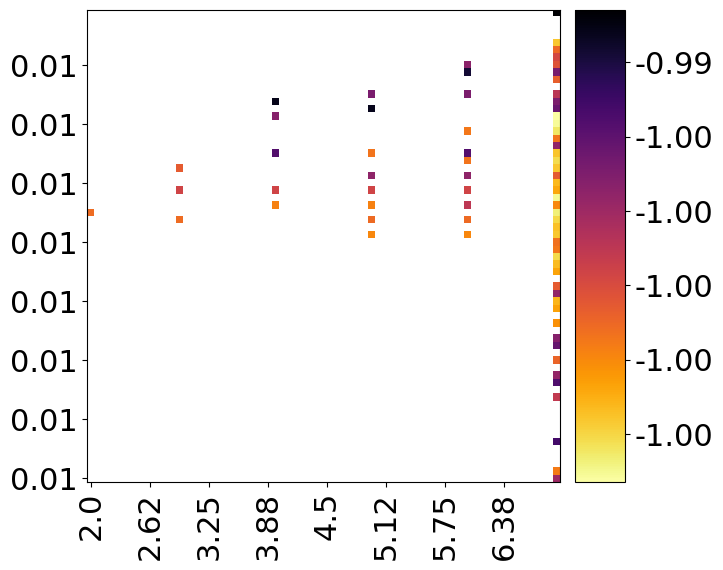

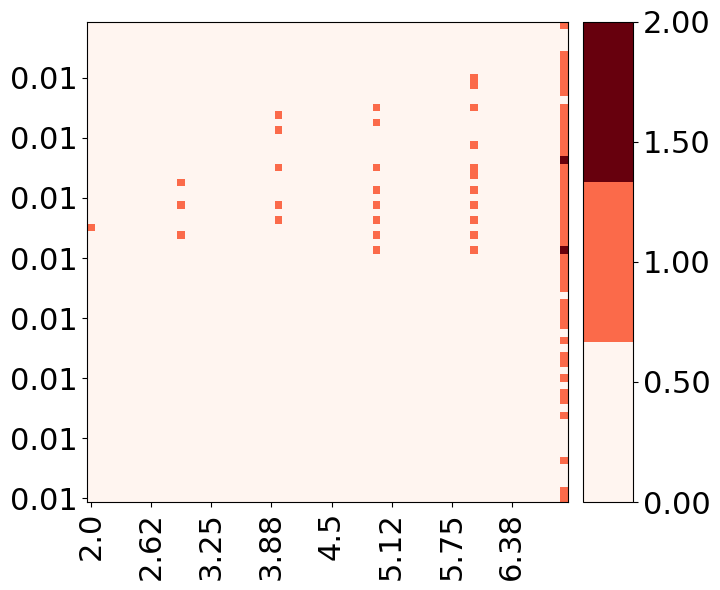

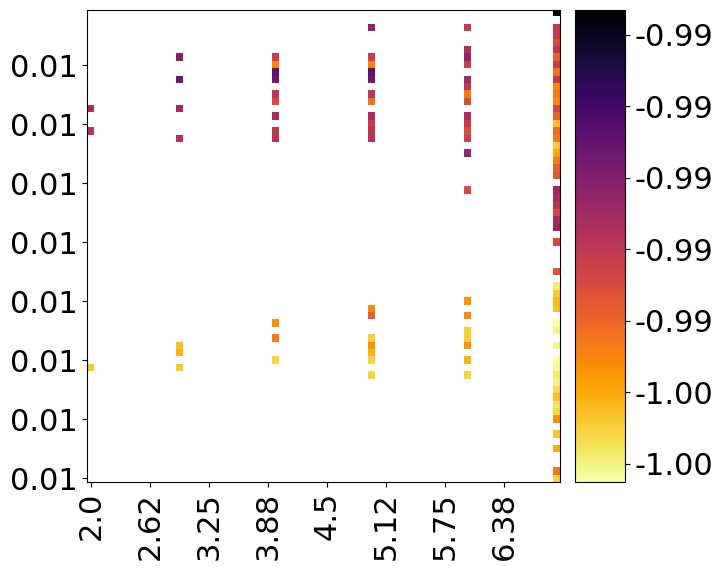

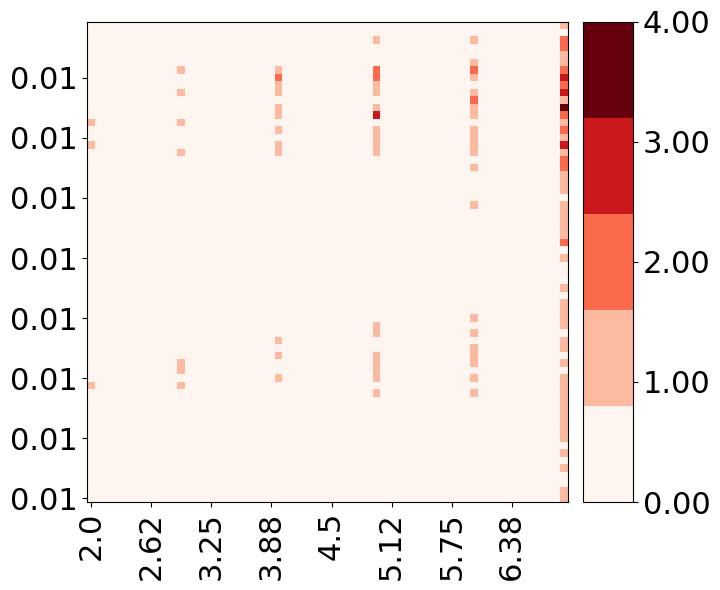

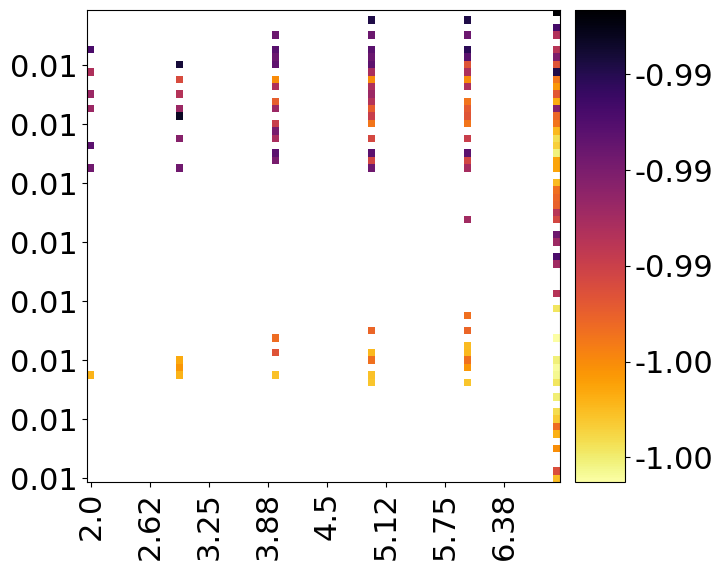

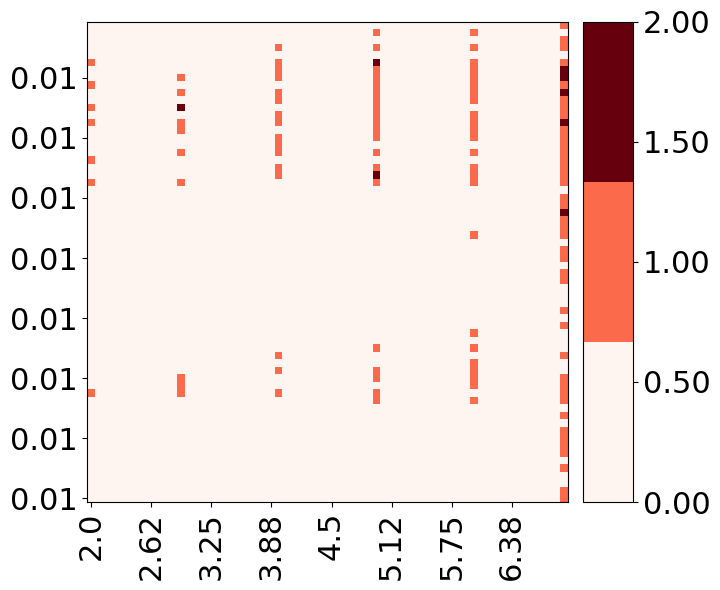

In [99]:
main(["",
    "20230904_0000",
    "20230904_0000",
    6,
    7,
    5,
    3,
    "input_relax_1e2"
])

In [100]:
# if __name__ == "__main__":
#     args = sys.argv
#     sys.exit(main(args))

(2023/7/26)<br>
・ループの原型ができたのでは？<br>
・実行に少々時間がかかるので、完了通知メールを送るプログラムも作っておいた。

In [101]:
# loop_num=3で実行時、loop1に入ろうとすると・・・
# make_model.pyのmake_model_for_loop(datasets_dirpath,results_dirpath)にて、
# TypeError: cannot unpack non-iterable NoneType object
# というエラーが出るのだが、手動でmake_model_for_loopを実行するとできてしまう。

(2023/7/27)<br>
・ひとまずのループ実行に成功。<br>
・最後に1つ余計なフォルダができてしまうのはご愛嬌。